# Objective¶
-Predict stock price in next day using simple moving average

-Given prices for the last N days, we do prediction for day N+1

In [1]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

np.warnings.filterwarnings('ignore')

%matplotlib inline

#### Input params ##################
stk_path = "AAPL_1980-2020_Historical.csv"
test_size = 0.2                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 21                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14
####################################

# Common Functions

In [2]:
def get_preds_mov_avg(df, target_col, N, pred_min, offset):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Using simple moving average.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'adj_close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : list. The predictions for target_col. np.array of length len(df)-offset.
    """
    pred_list = df[target_col].rolling(window = N, min_periods=1).mean() # len(pred_list) = len(df)
    
    # Add one timestep to the predictions
    pred_list = np.concatenate((np.array([np.nan]), np.array(pred_list[:-1])))
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
    
    return pred_list[offset:]

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Load Data 

In [3]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%m/%d/%y')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,date,open,high,low,close,adj_close,volume,month
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400,12
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200,12
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000,12
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400,12
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400,12
5,1980-12-19,0.504464,0.506696,0.504464,0.504464,0.399707,12157600,12
6,1980-12-22,0.529018,0.531250,0.529018,0.529018,0.419162,9340800,12
7,1980-12-23,0.551339,0.553571,0.551339,0.551339,0.436848,11737600,12
8,1980-12-24,0.580357,0.582589,0.580357,0.580357,0.459840,12000800,12
9,1980-12-26,0.633929,0.636161,0.633929,0.633929,0.502287,13893600,12


Text(0, 0.5, 'AAPL STOCK PRICE')

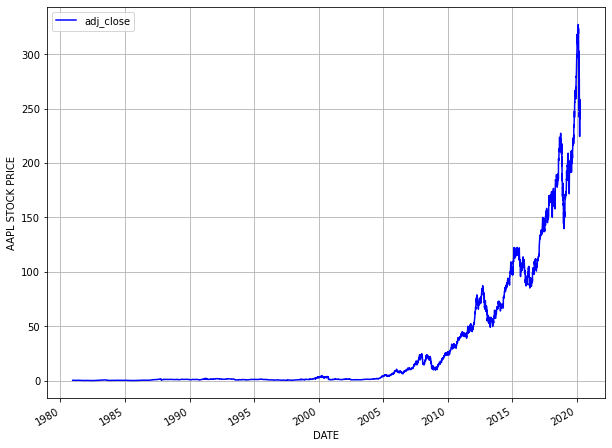

In [4]:
 # Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("DATE")
ax.set_ylabel("AAPL STOCK PRICE")

# Split into train, dev and test set

In [5]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 5947
num_cv = 1981
num_test = 1981
train.shape = (5947, 8)
cv.shape = (1981, 8)
train_cv.shape = (7928, 8)
test.shape = (1981, 8)


# EDA

Text(0, 0.5, 'USD')

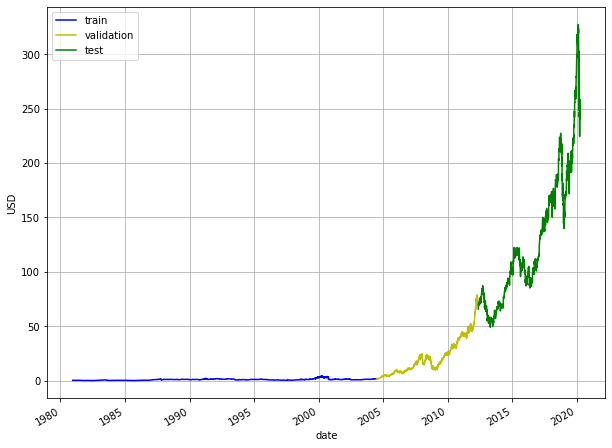

In [6]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Predict using Moving Average

In [7]:
RMSE = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_mov_avg(train_cv, 'adj_close', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['adj_close'])))
    mape.append(get_mape(cv['adj_close'], est_list))
print('RMSE = ' + str(RMSE))
print('MAPE = ' + str(mape))
df.head()

RMSE = [0.5269186720572353, 0.593174934566465, 0.6641081517254793, 0.7265849755292376, 0.7875989224633442, 0.8459660581734934, 0.9027656510748528, 0.9555634030537585, 1.0048419293266433, 1.0505793879865992, 1.096065267314426, 1.1413307081950452, 1.1857244610809887, 1.229386742709052, 1.2728211161757852, 1.3160416547975669, 1.3604942459221954, 1.4057163414236693, 1.4507966683572782, 1.4951650878078517, 1.539017524664525]
MAPE = [1.7394932447021278, 1.9623628320704922, 2.2281281263812502, 2.466981009358298, 2.7062372412810496, 2.9416679208947865, 3.1604197996032255, 3.3675758518004555, 3.5586849508925753, 3.738951817692055, 3.9115639274923675, 4.069957567380059, 4.222433262737407, 4.379441894389313, 4.536742760107999, 4.69056115020291, 4.843064313301088, 4.993860422055103, 5.143924588428274, 5.29280130833788, 5.435994455227135]


,date,open,high,low,close,adj_close,volume,month
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400,12
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200,12
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000,12
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400,12
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400,12


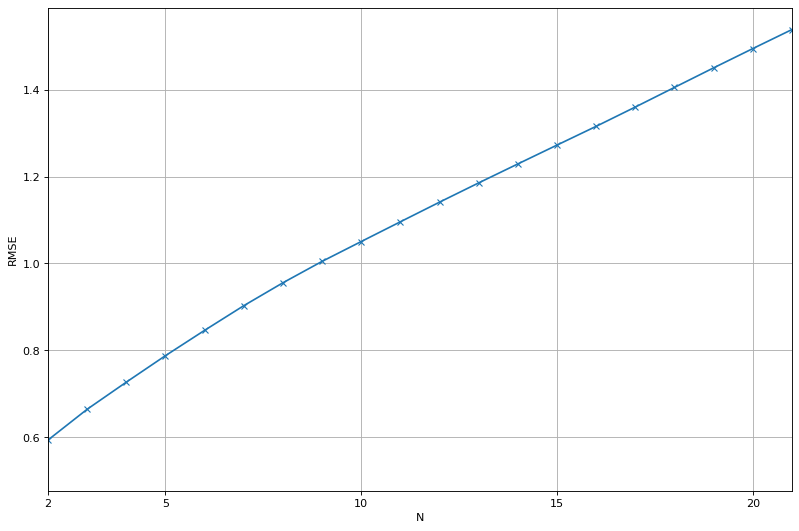

In [8]:
# Plot RMSE versus N
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
plt.xlim([2, 21])
plt.xticks([2, 5, 10, 15, 20])
matplotlib.rcParams.update({'font.size': 14})

# Plot Predictions on dev set

([<matplotlib.axis.XTick at 0x7fd659625240>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

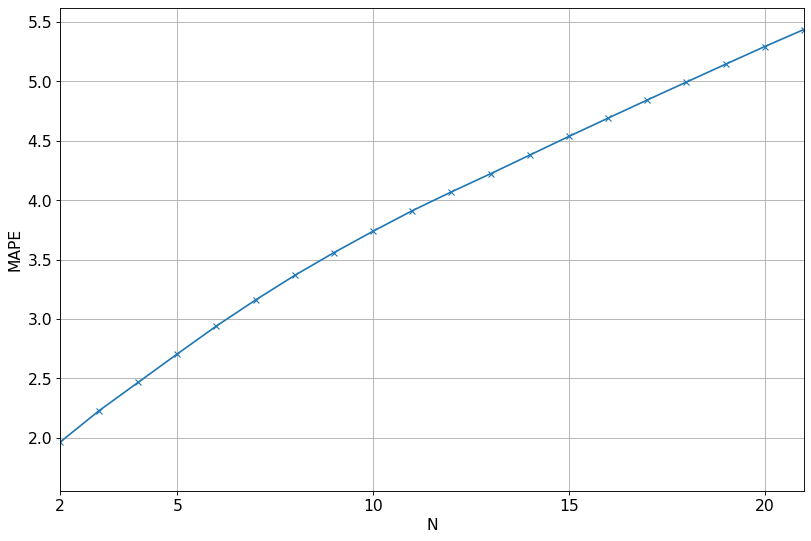

In [9]:
# Plot MAPE versus N. Note for MAPE smaller better. 
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')
plt.xlim([2, 21])
plt.xticks([2, 5, 10, 15, 20])

In [10]:
# Set optimum N
N_opt = 2

Text(0, 0.5, 'USD')

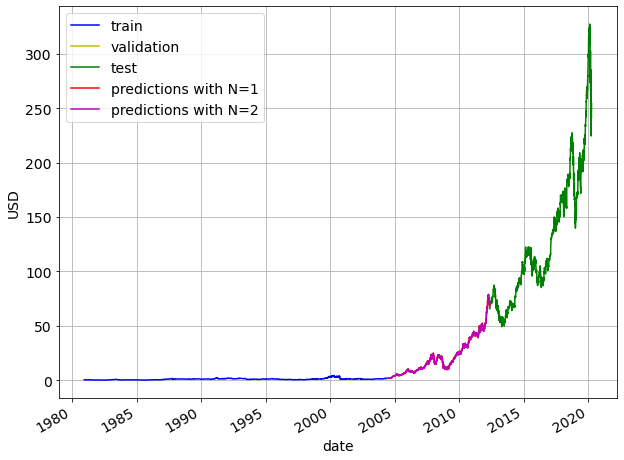

In [11]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N2', style='m-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N=1', 'predictions with N=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

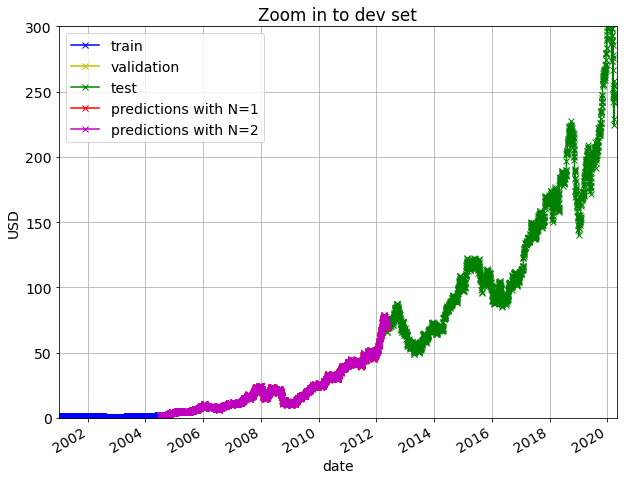

In [43]:
# ZOOM IN TEST

# # Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N2', style='mx-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N=1', 'predictions with N=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2000, 12, 31), date(2020, 4, 30)])
ax.set_ylim([0, 300])
ax.set_title('Zoom in to dev set')

# Final Model

In [13]:
est_list = get_preds_mov_avg(df, 'adj_close', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['adj_close'])))
print("MAPE = %0.3f%%" % get_mape(test['adj_close'], est_list))
test.head()

RMSE = 2.944
MAPE = 1.327%


,date,open,high,low,close,adj_close,volume,month,est_N2
7928,2012-05-17,77.901428,78.214287,75.731430,75.731430,65.737991,179305000,5,68.156689
7929,2012-05-18,76.279999,77.629997,74.597145,75.768570,65.770210,183073100,5,66.727547
7930,2012-05-21,76.357140,80.220001,76.292854,80.182854,69.601997,157776500,5,65.754101
7931,2012-05-22,81.364288,81.982857,78.940002,79.567146,69.067520,173717600,5,67.686104
7932,2012-05-23,79.642860,81.828575,79.032860,81.508568,70.752777,146224400,5,69.334759


Text(0, 0.5, 'USD')

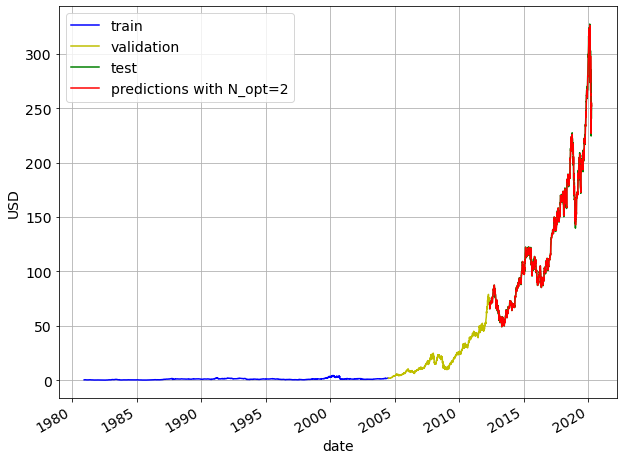

In [14]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N2', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

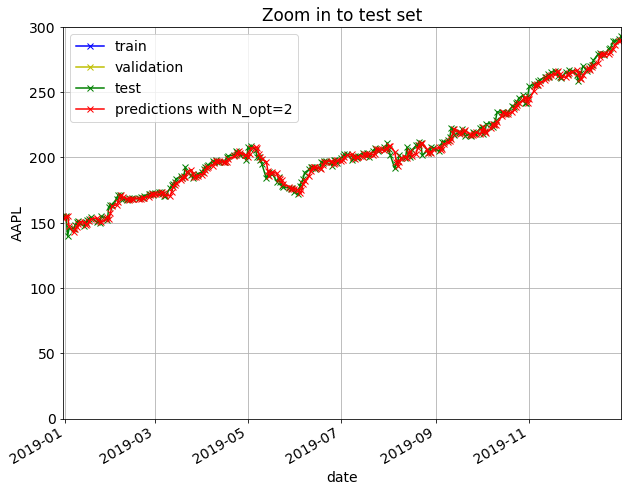

In [30]:
# ZOOM IN TEST

# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N2', style='rx-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=2'])
ax.set_xlabel("date")
ax.set_ylabel("AAPL")
ax.set_xlim([date(2018, 12, 31), date(2019, 12, 31)])
ax.set_ylim([0, 300])
ax.set_title('Zoom in to test set')

(130.0, 300.0)

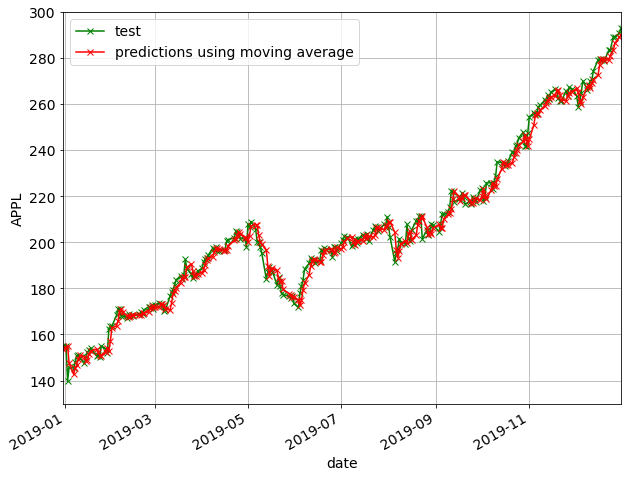

In [32]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = test.plot(x='date', y='est_N2', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using moving average'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("APPL")
ax.set_xlim([date(2018, 12, 31), date(2019, 12, 31)])
ax.set_ylim([130, 300])

In [44]:
# Save as csv
test_mov_avg = test
test_mov_avg.to_csv("test_mov_avg.csv")